## CuPy and PyCUDA comparison
Note that mixing pycuda and cupy isn't a very good idea, as the handling of CUDA contexts is different... But this works as far as demonstrating CuPy and PyCUDA give the same results.

In [1]:
%matplotlib notebook
import numpy as np
from scipy.misc import ascent, face
from scipy.fft import fftn, ifftn, rfftn, irfftn, fftshift
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

import cupy as cp

# This forces the CuPy context init
cupy_array = cp.zeros((4,4))

import pycuda
import pycuda.autoinit
import pycuda.gpuarray as cua
from pyvkfft.cuda import *


<class 'numpy.complex64'> False


<IPython.core.display.Javascript object>


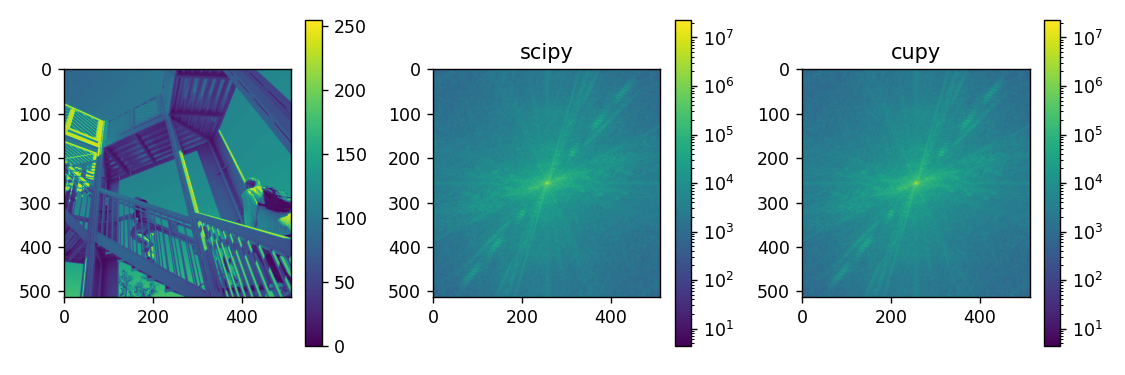

<class 'numpy.float32'> True


<IPython.core.display.Javascript object>


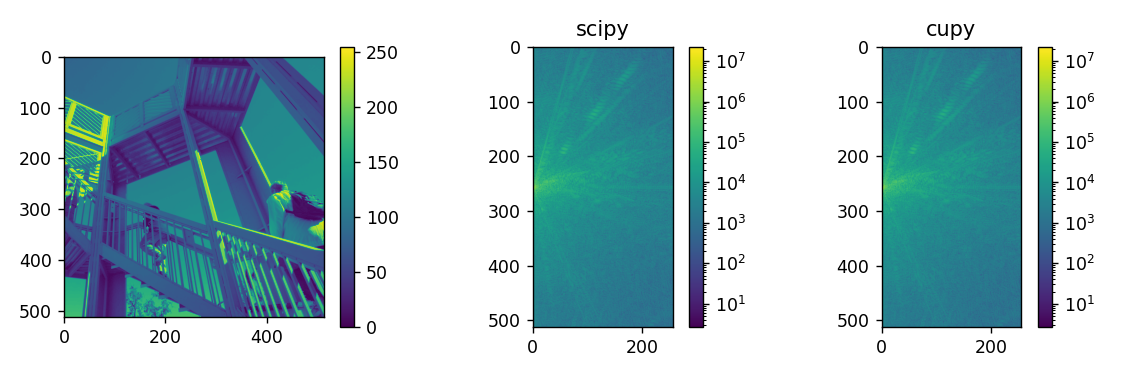

In [2]:
# Inplace, CuPy only
for dtype in [np.complex64, np.float32]:
    a = ascent().astype(dtype)

    app = VkFFTApp(a.shape, a.dtype, r2c=(a.dtype==np.float32))
    print(dtype, app.r2c)

    a_cupy = cp.asarray(a)

    plt.figure(figsize=(9.,3))
    plt.subplot(131)
    plt.imshow(abs(a))
    plt.colorbar()

    plt.subplot(132)
    if a.dtype == np.float32:
        b = rfftn(a[...,:-2])
        ax = [0]
    else:
        b = fftn(a)
        ax = None
    plt.imshow(abs(fftshift(b, axes=ax)), norm=LogNorm())
    plt.colorbar()
    plt.title("scipy")

    plt.subplot(133)
    a_cupy = app.fft(a_cupy)
    plt.imshow(abs(fftshift(a_cupy.get(), axes=ax)), norm=LogNorm())
    plt.colorbar()
    plt.title("cupy")


    plt.tight_layout()


<class 'numpy.complex64'> False


<IPython.core.display.Javascript object>


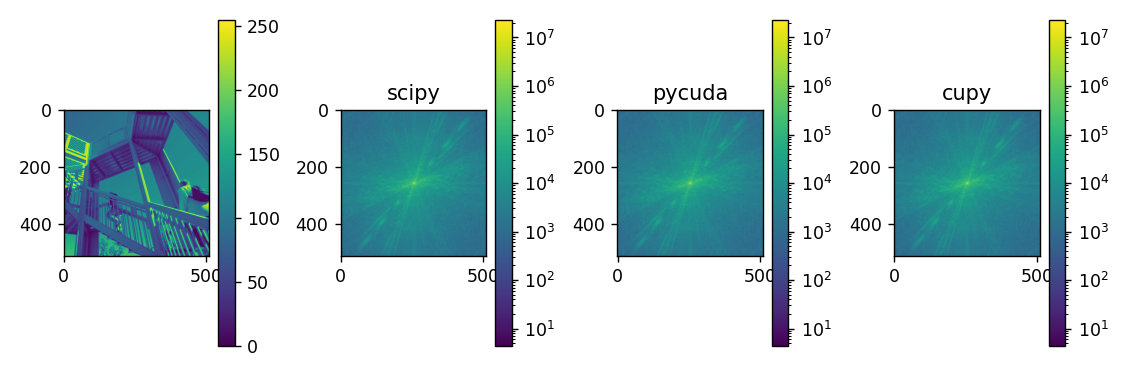

True
True
<class 'numpy.float32'> True


<IPython.core.display.Javascript object>


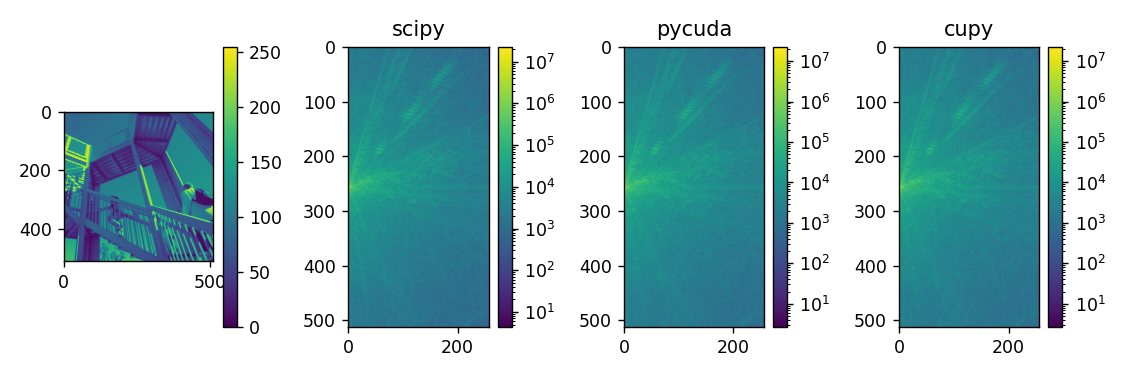

True
True


In [3]:
# Inplace
for dtype in [np.complex64, np.float32]:
    a = ascent().astype(dtype)

    app = VkFFTApp(a.shape, a.dtype, r2c=(a.dtype==np.float32))
    print(dtype, app.r2c)

    a_pycuda = cua.to_gpu(a)
    a_cupy = cp.asarray(a)

    plt.figure(figsize=(9.,3))
    plt.subplot(141)
    plt.imshow(abs(a))
    plt.colorbar()

    plt.subplot(142)
    if a.dtype == np.float32:
        ax = [0]
        plt.imshow(abs(fftshift(rfftn(a), axes=ax)), norm=LogNorm())
    else:
        ax=None
        plt.imshow(abs(fftshift(fftn(a))), norm=LogNorm())
    plt.colorbar()
    plt.title("scipy")

    plt.subplot(143)
    plt.imshow(abs(fftshift(app.fft(a_pycuda).get(), axes=ax)), norm=LogNorm())
    plt.colorbar()
    plt.title("pycuda")

    plt.subplot(144)
    plt.imshow(abs(fftshift(app.fft(a_cupy).get(), axes=ax)), norm=LogNorm())
    plt.colorbar()
    plt.title("cupy")


    plt.tight_layout()

    print(np.allclose(a_pycuda.get(), a_cupy.get()))
    
    app.ifft(a_pycuda)
    app.ifft(a_cupy)
    print(np.allclose(a_pycuda.get(), a_cupy.get()))


<class 'numpy.complex64'>


<IPython.core.display.Javascript object>


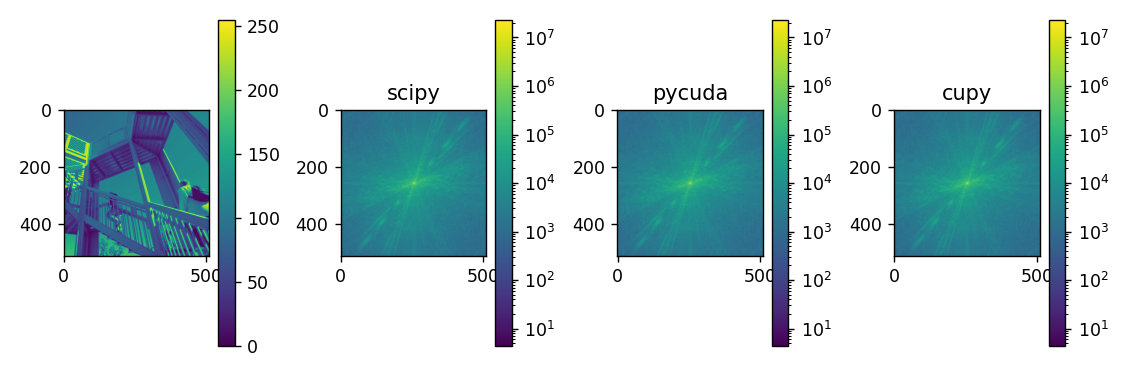

True
True
<class 'numpy.float32'>


<IPython.core.display.Javascript object>


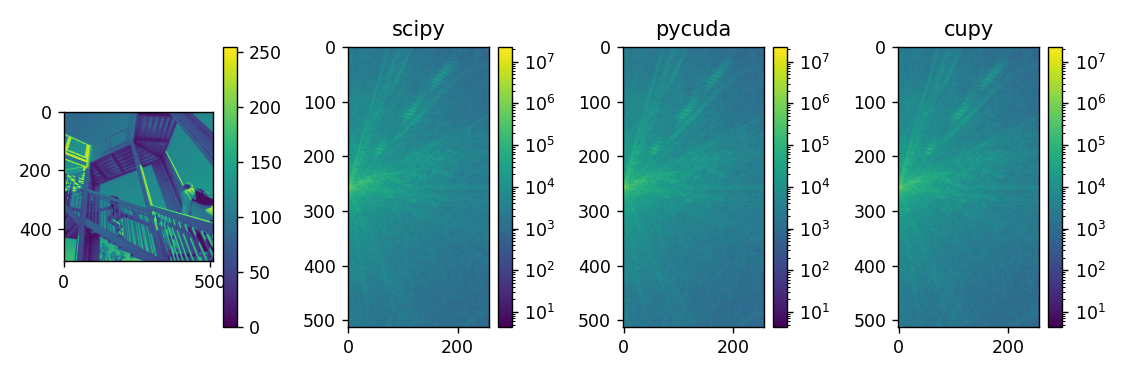

True
True


In [4]:
# Out-of-place
for dtype in [np.complex64, np.float32]:
    print(dtype)
    a = ascent().astype(dtype)

    app = VkFFTApp(a.shape, a.dtype, r2c=(a.dtype==np.float32), inplace=False)

    a_pycuda = cua.to_gpu(a)
    a_cupy = cp.asarray(a)
    if dtype == np.complex64:
        b_pycuda = cua.empty_like(a_pycuda)
        b_cupy = cp.empty_like(a_cupy)
    else:
        ny, nx = a.shape
        nx2 = nx //2 + 1
        b_pycuda = cua.empty((ny,nx2), np.complex64)
        b_cupy = cp.empty((ny,nx2), np.complex64)

    plt.figure(figsize=(9.,3))
    plt.subplot(141)
    plt.imshow(abs(a))
    plt.colorbar()

    plt.subplot(142)
    if a.dtype == np.float32:
        ax = [0]
        plt.imshow(abs(fftshift(rfftn(a), axes=ax)), norm=LogNorm())
    else:
        ax = None
        plt.imshow(abs(fftshift(fftn(a))), norm=LogNorm())
    plt.colorbar()
    plt.title("scipy")

    plt.subplot(143)
    plt.imshow(abs(fftshift(app.fft(a_pycuda, b_pycuda).get(), axes=ax)), norm=LogNorm())
    plt.colorbar()
    plt.title("pycuda")

    plt.subplot(144)
    plt.imshow(abs(fftshift(app.fft(a_cupy, b_cupy).get(), axes=ax)), norm=LogNorm())
    plt.colorbar()
    plt.title("cupy")


    plt.tight_layout()

    print(np.allclose(b_pycuda.get(), b_cupy.get()))
    
    app.ifft(b_pycuda, a_pycuda)
    app.ifft(b_cupy, a_cupy)
    print(np.allclose(a_pycuda.get(), a_cupy.get()))
